In [1]:
import random
import pandas
import seaborn
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.dense import Linear
from torch_geometric.nn import GCNConv, pool
from torch_geometric.utils import to_networkx, add_remaining_self_loops
from torch_geometric.loader import DataLoader

In [3]:
""" Create dataste of Pytorch Geometric Data objects """

nnodes = 100
dataset = []

for _ in range(2500):
    # create path grahp
    source_nodes, target_nodes = [], []
    edge_weights = []
    for i in range(1, nnodes+1):
        source_nodes += [(i-1) % nnodes, i % nnodes]
        target_nodes += [i % nnodes, (i-1) % nnodes]
        weight = random.uniform(-1, 1)
        edge_weights += [weight, weight]

    x = torch.tensor([[random.choice([-1, 1])] for _ in range(nnodes)], dtype=torch.float)
    edge_index = torch.LongTensor([source_nodes, target_nodes])
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    # calculate resulting energy
    energy = 0
    for i in range(1, nnodes):
        energy += x[i-1][0] * x[i][0] * edge_weights[(i-1)*2]
    
    # join into dataset
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights, y=energy/(nnodes*5))
    dataset.append(data)

# check if edges are encoded correctly
for data in dataset:
    assert data.edge_index.max() < data.num_nodes

In [4]:
""" 
Splitting and batching the dataset 

A data loader which merges data objects from a 
torch_geometric.data.Dataset to a mini-batch. 
Data objects can be either of type Data or HeteroData.
"""

split = (len(dataset) // 10) * 2
train_dataset = dataset[split:]
test_dataset = dataset[:split]

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=20)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)
print(f"Number of training graphs: {len(train_loader)}")
print(f"Number of testing graphs: {len(test_loader)}")

Number of training graphs: 100
Number of testing graphs: 50


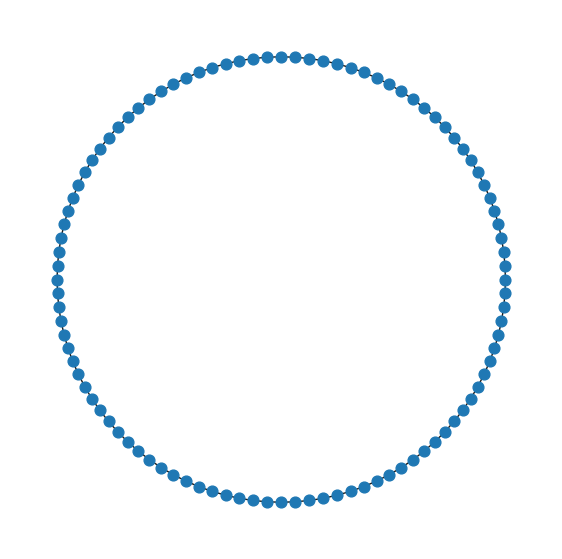

In [11]:
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_circular(G, node_size=60,font_size=8)
    plt.show()

graph = dataset[0]
G = to_networkx(graph, to_undirected=True)
visualize_graph(G)


In [6]:
""" Architecture of the neural network """

class GraphNetRegression(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(GraphNetRegression, self).__init__()
        self.conv = GCNConv(num_node_features, 8, improved=True)
        self.fc = Linear(8, num_output_features)

    def forward(self, x, edge_index, edge_weighs, batch):
        x = self.conv(x, edge_index, edge_weighs)
        x = F.relu(x)
        
        x = pool.global_mean_pool(x, batch)
        x = self.fc(x)
        
        x = x.flatten()
        return x


In [7]:
num_node_features = 1
num_output_features = 1
model = GraphNetRegression(num_node_features, num_output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
metric = torch.nn.MSELoss()

def train():
    model.train()
    # Iterate in batches over the training dataset.
    for data in train_loader:
        # Perform a single forward pass.
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        
        # Derive gradients
        loss = metric(out, data.y) 
        loss.backward()
        
        # Update parameters based on gradients.
        optimizer.step()
        optimizer.zero_grad()


def test(loader, epoch):
     model.eval()
     mse_loss = 0
     for data in loader:
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)  
        loss = metric(out, data.y) 
        mse_loss += loss
     return float(mse_loss) / len(loader)

In [8]:
""" Model parameters """

print("Sum of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
for data in train_loader:
    print(torch_geometric.nn.summary(model, data.x, data.edge_index, data.edge_weight, data.batch))
    break

Sum of trainable parameters:  25
+--------------------+------------------------------+----------------+----------+
| Layer              | Input Shape                  | Output Shape   |   #Param |
|--------------------+------------------------------+----------------+----------|
| GraphNetRegression | [2000, 1], [2, 4000], [2000] | [20]           |       25 |
| ├─(conv)GCNConv    | [2000, 1], [2, 4000]         | [2000, 8]      |       16 |
| ├─(fc)Linear       | [20, 8]                      | [20, 1]        |        9 |
+--------------------+------------------------------+----------------+----------+


Epoch: 000, Train Loss: 0.09132156, Test Loss: 0.09157908
Epoch: 001, Train Loss: 0.07593293, Test Loss: 0.07620145
Epoch: 002, Train Loss: 0.06220317, Test Loss: 0.06247271
Epoch: 003, Train Loss: 0.04999543, Test Loss: 0.05025900
Epoch: 004, Train Loss: 0.03929980, Test Loss: 0.03955060
Epoch: 005, Train Loss: 0.03015296, Test Loss: 0.03038614
Epoch: 006, Train Loss: 0.02245640, Test Loss: 0.02266816
Epoch: 007, Train Loss: 0.01621862, Test Loss: 0.01640637
Epoch: 008, Train Loss: 0.01135083, Test Loss: 0.01151327
Epoch: 009, Train Loss: 0.00770140, Test Loss: 0.00783849
Epoch: 010, Train Loss: 0.00506685, Test Loss: 0.00517957
Epoch: 011, Train Loss: 0.00322485, Test Loss: 0.00331464
Epoch: 012, Train Loss: 0.00200369, Test Loss: 0.00207276
Epoch: 013, Train Loss: 0.00126074, Test Loss: 0.00131244
Epoch: 014, Train Loss: 0.00083683, Test Loss: 0.00087461
Epoch: 015, Train Loss: 0.00060789, Test Loss: 0.00063494
Epoch: 016, Train Loss: 0.00048936, Test Loss: 0.00050833
Epoch: 017, Tr

Text(0, 0.5, 'MSE loss')

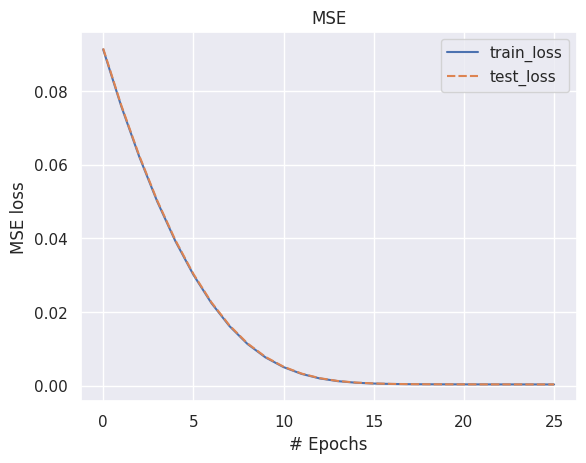

In [9]:
epoch = 25
train_loss, test_loss = [], []
for epoch in range(epoch+1):
    train()
    train_loss.append(test(train_loader, epoch))
    test_loss.append(test(test_loader, epoch))
    # wandb.log({"acc": train_loss[-1], "loss": test_loss[-1]})
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss[-1]:.8f}, Test Loss: {test_loss[-1]:.8f}')

loss_df = pandas.DataFrame({'epochs': range(epoch+1), 'train_loss': train_loss, 'test_loss': test_loss})

seaborn.set_theme()
loss_plot = seaborn.lineplot(loss_df[['train_loss', 'test_loss']])
loss_plot.set_title("MSE")
loss_plot.set_xlabel("# Epochs")
loss_plot.set_ylabel("MSE loss")

Text(0.5, 1.0, 'Frequency of loss')

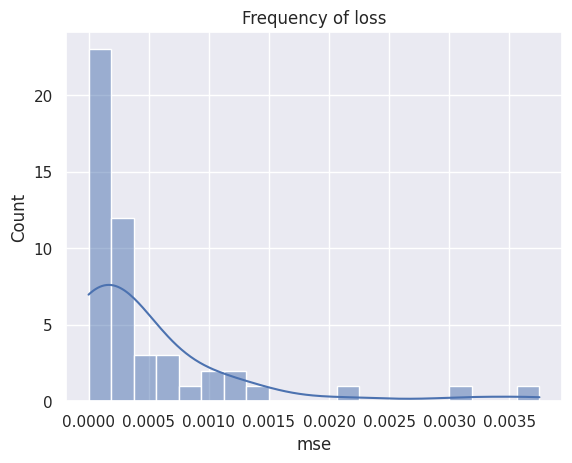

In [10]:
pred_df = pandas.DataFrame(columns=['pred', 'y_true', 'mse'])
model.eval()
for idx, data in enumerate(test_loader):
    out = model(data.x, data.edge_index, data.edge_weight, data.batch)
    for i in range(len(out)):
        pred_df.loc[idx] = [float(out[i]), float(data.y[i]), float(F.mse_loss(out[i], data.y[i]))]

loss_freq_plot = seaborn.histplot(pred_df['mse'], bins=20, kde=True)
loss_freq_plot.set_title("Frequency of loss")